Generate plots

In [1]:
import numpy as np
import pandas as pd
import pickle
import joypy
from pathlib import Path

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
results_folder = project_folder_path + 'results\\synthetic\\results\\bin_size_runs\\'
fig_folder = project_folder_path + 'results\\synthetic\\figures\\'

In [3]:
save_fig = False

### Load summary dataframes

ACF, iSTTC, PersonR, iSTTC trails (сoncat)

ACF vs iSTTC, full signal

PearsonR vs iSTTC (concat and avg), trails

In [8]:
def long_to_wide(df, spec, index_cols=None, value_col="tau_diff_rel"):
    """
    Convert a long tau df to wide.

    spec: dict {new_column_name -> method_name_in_df}
          e.g. {"tau_diff_rel_acf": "acf_full", "tau_diff_rel_isttc": "isttc_full"}
    index_cols: columns that identify a unit 
    value_col: the value column to pivot (default: "tau_diff_rel")
    """
    if index_cols is None:
        index_cols = ["unit_id", "fr", "alpha", "lv", "tau_ms_true"]
    methods = list(spec.values())
    tmp = df.loc[df["method"].isin(methods),
                 index_cols + ["method", value_col]]
    wide = tmp.pivot(index=index_cols, columns="method", values=value_col)
    wide = wide.rename(columns={m: new for new, m in spec.items()})
    return wide.reset_index()

def inspect(df, name):
    print(f"len {name}: {len(df)}")
    print(df.columns.tolist())

results_folder = Path(results_folder)

# From summary_tau_full_long_acf_lags_df
print('ACF, iSTTC, PersonR, iSTTC trails (сoncat)')
df_all = pd.read_pickle(results_folder / "summary_tau_full_long_acf_lags_df.pkl")
inspect(df_all, "df_all (all)")

df_isttc_all = pd.read_pickle(results_folder / "summary_tau_full_long_acf_isttc_lags_df.pkl")
inspect(df_isttc_all, "df_isttc_all (all)")

ACF, iSTTC, PersonR, iSTTC trails (сoncat)
len df_all (all): 589548
['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared', 'acf_decline', 'method', 'tau_ms', 'duration_s', 'fr', 'alpha', 'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'n_lags', 'lv']
len df_isttc_all (all): 199228
['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared', 'acf_decline', 'method', 'tau_ms', 'duration_s', 'fr', 'alpha', 'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'n_lags', 'lv']


### Prepare extra dataframes for plotting 

In [5]:
# extract the reference tau_ms for n_lags=20
ref = df_all[df_all['n_lags'] == 20][['unit_id', 'tau_ms']]
ref = ref.rename(columns={'tau_ms': 'tau_ms_ref'})

# merge reference back onto the full dataframe
merged = df_all.merge(ref, on='unit_id', how='left')

# compute the difference
merged['tau_ms_diff'] = merged['tau_ms'] - merged['tau_ms_ref']

merged['tau_ms_diff_log10'] = np.log10(np.abs(merged['tau_ms_diff']) + 1)
merged['tau_diff_rel_log10'] = np.log10(merged['tau_diff_rel'])

merged

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,duration_s,fr,...,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,n_lags,lv,tau_ms_ref,tau_ms_diff,tau_ms_diff_log10,tau_diff_rel_log10
0,0,2.217899,2.119224,2.316575,0.998369,True,acf_full,110.894975,600,7.741821,...,150.923515,40.028540,26.522401,0.197350,20,1.307775,110.894975,0.000000,0.000000,1.423613
1,1,2.568210,2.437150,2.699270,0.997899,True,acf_full,128.410512,600,4.394396,...,147.947233,19.536721,13.205195,0.262120,20,1.345006,128.410512,0.000000,0.000000,1.120745
2,2,5.227451,4.334421,6.120482,0.984960,True,acf_full,261.372568,600,8.587393,...,267.002290,5.629722,2.108492,1.786061,20,1.068416,261.372568,0.000000,0.000000,0.323972
3,3,3.950209,2.250084,5.650335,0.889719,True,acf_full,197.510466,600,6.976707,...,194.403797,3.106670,1.598050,3.400250,20,1.055631,197.510466,0.000000,0.000000,0.203590
4,4,3.717963,3.426456,4.009471,0.995737,True,acf_full,185.898174,600,0.950832,...,239.986489,54.088315,22.538067,0.583014,20,1.357205,185.898174,0.000000,0.000000,1.352917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589543,99994,4.475841,3.973274,4.978407,0.995573,True,acf_full,268.550442,600,6.938018,...,239.402724,29.147718,12.175182,1.005133,16,1.136797,264.990762,3.559680,0.658934,1.085475
589544,99995,1.733853,1.109046,2.358661,0.929727,True,acf_full,104.031199,600,2.672839,...,125.243251,21.212051,16.936682,1.249615,16,1.178739,111.382499,-7.351300,0.921754,1.228828
589545,99996,1.391714,1.303135,1.480294,0.997707,True,acf_full,83.502854,600,5.754497,...,94.481295,10.978440,11.619697,0.177159,16,1.353800,87.281338,-3.778484,0.679290,1.065195
589546,99997,2.321685,1.379654,3.263715,0.915569,True,acf_full,139.301076,600,5.604441,...,174.189672,34.888597,20.029084,1.884061,16,1.064661,149.742178,-10.441102,1.058468,1.301661


In [9]:
# extract the reference tau_ms for n_lags=20
ref = df_isttc_all[df_isttc_all['n_lags'] == 20][['unit_id', 'tau_ms']]
ref = ref.rename(columns={'tau_ms': 'tau_ms_ref'})

# merge reference back onto the full dataframe
merged_isttc = df_isttc_all.merge(ref, on='unit_id', how='left')

# compute the difference
merged_isttc['tau_ms_diff'] = merged_isttc['tau_ms'] - merged_isttc['tau_ms_ref']

merged_isttc['tau_ms_diff_log10'] = np.log10(np.abs(merged_isttc['tau_ms_diff']) + 1)
merged_isttc['tau_diff_rel_log10'] = np.log10(merged_isttc['tau_diff_rel'])

merged_isttc

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,duration_s,fr,...,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,n_lags,lv,tau_ms_ref,tau_ms_diff,tau_ms_diff_log10,tau_diff_rel_log10
0,0,2.523412,2.362379,2.684445,0.996707,True,acf_isttc_full,126.170618,600,7.741821,...,150.923515,24.752897,16.400954,0.322066,20,1.307775,126.170618,0.000000,0.000000,1.214869
1,1,2.834326,2.688470,2.980182,0.997916,True,acf_isttc_full,141.716309,600,4.394396,...,147.947233,6.230924,4.211585,0.291712,20,1.345006,141.716309,0.000000,0.000000,0.624446
2,2,4.855442,4.132395,5.578488,0.987654,True,acf_isttc_full,242.772076,600,8.587393,...,267.002290,24.230214,9.074909,1.446094,20,1.068416,242.772076,0.000000,0.000000,0.957842
3,3,4.460909,2.176731,6.745087,0.862334,True,acf_isttc_full,223.045437,600,6.976707,...,194.403797,28.641641,14.733066,4.568356,20,1.055631,223.045437,0.000000,0.000000,1.168293
4,4,4.609823,4.280359,4.939287,0.996987,True,acf_isttc_full,230.491166,600,0.950832,...,239.986489,9.495323,3.956607,0.658928,20,1.357205,230.491166,0.000000,0.000000,0.597323
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199223,99994,6.419044,5.965070,6.873018,0.996428,True,acf_isttc_full,256.761759,600,6.938018,...,239.402724,17.359035,7.250977,0.907947,25,1.136797,254.250387,2.511373,0.545477,0.860396
199224,99995,2.589732,1.407417,3.772048,0.808265,False,acf_isttc_full,103.589296,600,2.672839,...,125.243251,21.653955,17.289518,2.364631,25,1.178739,99.306590,4.282706,0.722856,1.237783
199225,99996,2.105757,1.978118,2.233396,0.995823,True,acf_isttc_full,84.230277,600,5.754497,...,94.481295,10.251018,10.849785,0.255277,25,1.353800,82.286403,1.943874,0.468919,1.035421
199226,99997,3.749265,2.385295,5.113235,0.878162,True,acf_isttc_full,149.970608,600,5.604441,...,174.189672,24.219065,13.903847,2.727940,25,1.064661,145.325980,4.644627,0.751635,1.143135


In [17]:
df_acf_best = merged.loc[merged.groupby('unit_id')['tau_diff_rel'].idxmin()].reset_index(drop=True)
df_acf_best

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,duration_s,fr,...,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,n_lags,lv,tau_ms_ref,tau_ms_diff,tau_ms_diff_log10,tau_diff_rel_log10
0,0,11.582844,11.343647,11.822041,0.997618,True,acf_full,115.828439,600,7.741821,...,150.923515,35.095076,23.253551,0.478394,100,1.307775,110.894975,4.933465,0.773308,1.366489
1,1,13.111673,12.813685,13.409662,0.997211,True,acf_full,131.116732,600,4.394396,...,147.947233,16.830501,11.376016,0.595977,100,1.345006,128.410512,2.706220,0.568931,1.055990
2,2,4.390605,3.654937,5.126273,0.989985,True,acf_full,263.436315,600,8.587393,...,267.002290,3.565974,1.335559,1.471336,16,1.068416,261.372568,2.063747,0.486253,0.125663
3,3,7.751028,5.538455,9.963600,0.883178,True,acf_full,193.775690,600,6.976707,...,194.403797,0.628106,0.323094,4.425145,40,1.055631,197.510466,-3.734776,0.675299,-0.490672
4,4,5.200976,4.631338,5.770614,0.989696,True,acf_full,208.039029,600,0.950832,...,239.986489,31.947459,13.312191,1.139276,25,1.357205,185.898174,22.140855,1.364379,1.124250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98253,99994,5.299815,4.908895,5.690736,0.997203,True,acf_full,264.990762,600,6.938018,...,239.402724,25.588038,10.688282,0.781841,20,1.136797,264.990762,0.000000,0.000000,1.028908
98254,99995,4.786764,2.679129,6.894399,0.719619,False,acf_full,119.669105,600,2.672839,...,125.243251,5.574146,4.450656,4.215270,40,1.178739,111.382499,8.286605,0.967857,0.648424
98255,99996,9.079185,8.680814,9.477556,0.988898,True,acf_full,90.791853,600,5.754497,...,94.481295,3.689442,3.904944,0.796742,100,1.353800,87.281338,3.510515,0.654226,0.591615
98256,99997,16.965994,10.910056,23.021932,0.618246,False,acf_full,169.659941,600,5.604441,...,174.189672,4.529732,2.600459,12.111876,100,1.064661,149.742178,19.917763,1.320515,0.415050


In [18]:
df_acf_best.groupby(by='n_lags').count()

,unit_id,tau,tau_lower,tau_upper,fit_r_squared,acf_decline,method,tau_ms,duration_s,fr,alpha,tau_ms_true,tau_diff_abs,tau_diff_rel,ci_width,lv,tau_ms_ref,tau_ms_diff,tau_ms_diff_log10,tau_diff_rel_log10
n_lags,,,,,,,,,,,,,,,,,,,,
10,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547,19547
16,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259,13259
20,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243,11243
25,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657,11657
40,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032,13032
100,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520,29520


### Plots

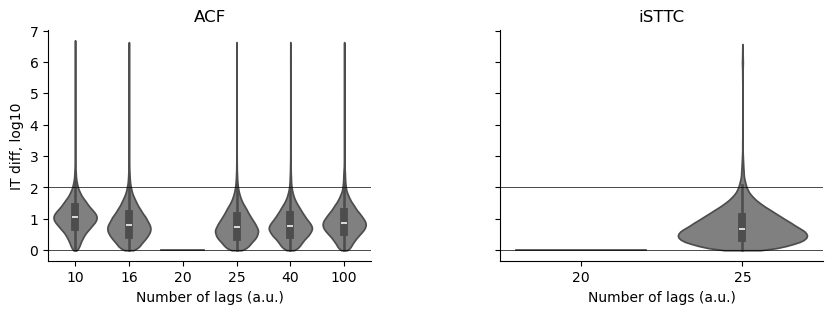

In [15]:
color = 'gray'

fig, axes = plt.subplots(1,2, figsize=(10,3), sharey=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(x='n_lags', y='tau_ms_diff_log10', data=merged , cut=0, density_norm='width', 
               legend=False, color=color, ax=axes[0])
axes[0].set_title('ACF')

sns.violinplot(x='n_lags', y='tau_ms_diff_log10', data=merged_isttc , cut=0, density_norm='width', 
               legend=False, color=color, ax=axes[1])
axes[1].set_title('iSTTC')

#axes.set_xticklabels(['10', '20\n(reference)', '100'])

for ax in axes:
    ax.set_ylabel('IT diff, log10')
    ax.set_xlabel('Number of lags (a.u.)')
    ax.axhline(y=2, lw=0.5, c='k')
    ax.axhline(y=0, lw=0.5, c='k')
    sns.despine(ax=ax)

# if save_fig:
#     plt.savefig(fig_folder + 'isttc_concat_zeros.png' , bbox_inches='tight', dpi=300)
#     plt.savefig(fig_folder + 'isttc_concat_zeros.svg' , bbox_inches='tight')

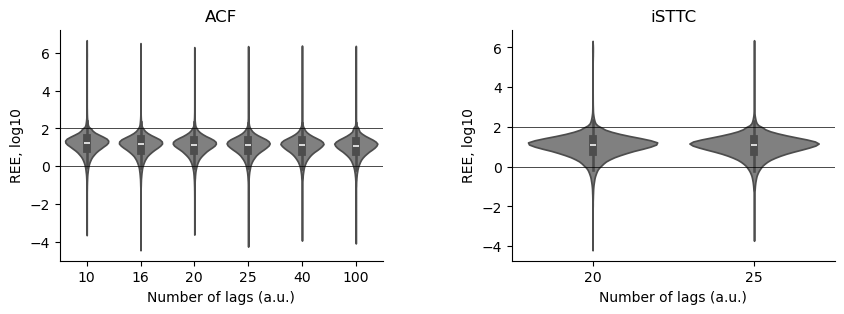

In [16]:
color = 'gray'

fig, axes = plt.subplots(1,2, figsize=(10,3))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

sns.violinplot(x='n_lags', y='tau_diff_rel_log10', data=merged , cut=0, density_norm='width', 
               legend=False, color=color, ax=axes[0])
axes[0].set_title('ACF')

sns.violinplot(x='n_lags', y='tau_diff_rel_log10', data=merged_isttc , cut=0, density_norm='width', 
               legend=False, color=color, ax=axes[1])
axes[1].set_title('iSTTC')

for ax in axes.flat:
    ax.axhline(y=2, lw=0.5, c='k')
    ax.axhline(y=0, lw=0.5, c='k')
    ax.set_ylabel('REE, log10')
    ax.set_xlabel('Number of lags (a.u.)')
    sns.despine(ax=ax)